# Market Basket Analysis

### Loading Required Libraries

In [97]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import numpy as np
import warnings
import collections as col
import itertools as iterto
warnings.filterwarnings("ignore")
from sklearn.cluster import KMeans #for kmeans algorithm
#For dimensionality reduction.
from sklearn.decomposition import PCA #pca from decomposition module.
from sklearn.preprocessing import StandardScaler
from sklearn import decomposition #decomposition module

## Data Loading and Cleaning

### Reading Input Files

In [2]:
aisles = pd.read_csv('https://raw.githubusercontent.com/yashwanthky/Market_Basket_Analysis/Data_Loading/aisles_perishables_tagged.csv', index_col = 0, error_bad_lines = False).reset_index()
departments = pd.read_csv('instacart_2017_05_01/departments.csv')
products = pd.read_csv('instacart_2017_05_01/products.csv')
orders = pd.read_csv('instacart_2017_05_01/orders.csv')
orders_products_train = pd.read_csv('instacart_2017_05_01/order_products__prior.csv')  # We train the model using this data of n-1 orders
orders_products_test = pd.read_csv('instacart_2017_05_01/order_products__train.csv')   # We validate the predictions with this data of the nth order

In [3]:
aisles.head()

,aisle_id,aisle,Perishables
0,1,prepared soups salads,1
1,2,specialty cheeses,1
2,3,energy granola bars,0
3,4,instant foods,0
4,5,marinades meat preparation,1


### Data Check
#### (shape, features, unique values and missing values)

In [4]:
print ("Rows     : " ,aisles.shape[0])
print ("Columns  : " ,aisles.shape[1])
print ("\nFeatures : \n" ,aisles.columns.tolist())
print ("\nMissing values :  ", aisles.isnull().sum().values.sum())
print ("\nUnique values :  \n",aisles.nunique())

Rows     :  134
Columns  :  3

Features : 
 ['aisle_id', 'aisle', 'Perishables']

Missing values :   0

Unique values :  
 aisle_id       134
aisle          134
Perishables      2
dtype: int64


In [5]:
print ("Rows     : " ,departments.shape[0])
print ("Columns  : " ,departments.shape[1])
print ("\nFeatures : \n" ,departments.columns.tolist())
print ("\nMissing values :  ", departments.isnull().sum().values.sum())
print ("\nUnique values :  \n",departments.nunique())

Rows     :  21
Columns  :  2

Features : 
 ['department_id', 'department']

Missing values :   0

Unique values :  
 department_id    21
department       21
dtype: int64


In [6]:
print ("Rows     : " ,products.shape[0])
print ("Columns  : " ,products.shape[1])
print ("\nFeatures : \n" ,products.columns.tolist())
print ("\nMissing values :  ",products.isnull().sum().values.sum())
print ("\nUnique values :  \n",products.nunique())

Rows     :  49688
Columns  :  4

Features : 
 ['product_id', 'product_name', 'aisle_id', 'department_id']

Missing values :   0

Unique values :  
 product_id       49688
product_name     49688
aisle_id           134
department_id       21
dtype: int64


In [7]:
print ("Rows     : " ,orders.shape[0])
print ("Columns  : " ,orders.shape[1])
print ("\nFeatures : \n" ,orders.columns.tolist())
print ("\nMissing values :  ", orders.isnull().sum().values.sum())
print ("\nMissing values :  ", orders.isnull().sum().values)
print ("\nUnique values :  \n",orders.nunique())

Rows     :  3421083
Columns  :  7

Features : 
 ['order_id', 'user_id', 'eval_set', 'order_number', 'order_dow', 'order_hour_of_day', 'days_since_prior_order']

Missing values :   206209

Missing values :   [     0      0      0      0      0      0 206209]

Unique values :  
 order_id                  3421083
user_id                    206209
eval_set                        3
order_number                  100
order_dow                       7
order_hour_of_day              24
days_since_prior_order         31
dtype: int64


There are 206,209 missing values in the column 'days_since_prior_order'. This means that these orders are the first orders for the 206,209 unique customers

In [8]:
# Let us see the order count by unique user id

print(orders.groupby('user_id').agg({'order_id' : ['count']}).min(),
      orders.groupby('user_id').agg({'order_id' : ['count']}).max(),
     orders.groupby('user_id').agg({'order_id' : ['count']}).mean(),
     orders.groupby('user_id').agg({'order_id' : ['count']}).median(),
     orders.groupby('user_id').agg({'order_id' : ['count']}).std())

order_id  count    4
dtype: int64 order_id  count    100
dtype: int64 order_id  count    16.590367
dtype: float64 order_id  count    10.0
dtype: float64 order_id  count    16.654774
dtype: float64


There are around 10 orders for 75% of the customers and the minimum number of orders per user is 4 and the maximum number of orders per user is 100.

In [9]:
print ("Rows     : " ,orders_products_train.shape[0])
print ("Columns  : " ,orders_products_train.shape[1])
print ("\nFeatures : \n" ,orders_products_train.columns.tolist())
print ("\nMissing values :  ", orders_products_train.isnull().sum().values.sum())
print ("\nUnique values :  \n",orders_products_train.nunique())

Rows     :  32434489
Columns  :  4

Features : 
 ['order_id', 'product_id', 'add_to_cart_order', 'reordered']

Missing values :   0

Unique values :  
 order_id             3214874
product_id             49677
add_to_cart_order        145
reordered                  2
dtype: int64


In [10]:
print ("Rows     : " ,orders_products_test.shape[0])
print ("Columns  : " ,orders_products_test.shape[1])
print ("\nFeatures : \n" ,orders_products_test.columns.tolist())
print ("\nMissing values :  ", orders_products_test.isnull().sum().values.sum())
print ("\nUnique values :  \n",orders_products_test.nunique())

Rows     :  1384617
Columns  :  4

Features : 
 ['order_id', 'product_id', 'add_to_cart_order', 'reordered']

Missing values :   0

Unique values :  
 order_id             131209
product_id            39123
add_to_cart_order        80
reordered                 2
dtype: int64


## Data Merging

In [11]:
merged_data = pd.merge(orders_products_train,orders, on = 'order_id')
merged_data = pd.merge(merged_data,products, on = 'product_id')
merged_data = pd.merge(merged_data,aisles, on = 'aisle_id')
merged_data = pd.merge(merged_data,departments, on = 'department_id')

Replacing the missing values in the column 'days_since_prior_order' with '999'

In [12]:
merged_data['days_since_prior_order'].fillna('999',inplace = True)

In [13]:
print ("Rows     : " ,merged_data.shape[0])
print ("Columns  : " ,merged_data.shape[1])
print ("\nMissing values :  ",list(zip(merged_data.columns.tolist(),list(merged_data.isnull().sum().values))))
print ("\nUnique values :  \n",merged_data.nunique())

Rows     :  32434489
Columns  :  16

Missing values :   [('order_id', 0), ('product_id', 0), ('add_to_cart_order', 0), ('reordered', 0), ('user_id', 0), ('eval_set', 0), ('order_number', 0), ('order_dow', 0), ('order_hour_of_day', 0), ('days_since_prior_order', 0), ('product_name', 0), ('aisle_id', 0), ('department_id', 0), ('aisle', 0), ('Perishables', 0), ('department', 0)]

Unique values :  
 order_id                  3214874
product_id                  49677
add_to_cart_order             145
reordered                       2
user_id                    206209
eval_set                        1
order_number                   99
order_dow                       7
order_hour_of_day              24
days_since_prior_order         32
product_name                49677
aisle_id                      134
department_id                  21
aisle                         134
Perishables                     2
department                     21
dtype: int64


## Data Exploration

#### Count of users by number of orders placed

We will look at the distribution of number of orders placed by each user - 

In [14]:
user_order = merged_data[['user_id','order_id']].drop_duplicates().groupby(['user_id']).agg({'order_id' : ['count']}).reset_index()
user_order.columns = ['user_id','Orders_Count']
user_order = user_order.groupby(['Orders_Count']).agg({'user_id' : ['count']}).reset_index()
user_order.columns = ['Order_Count','Users']

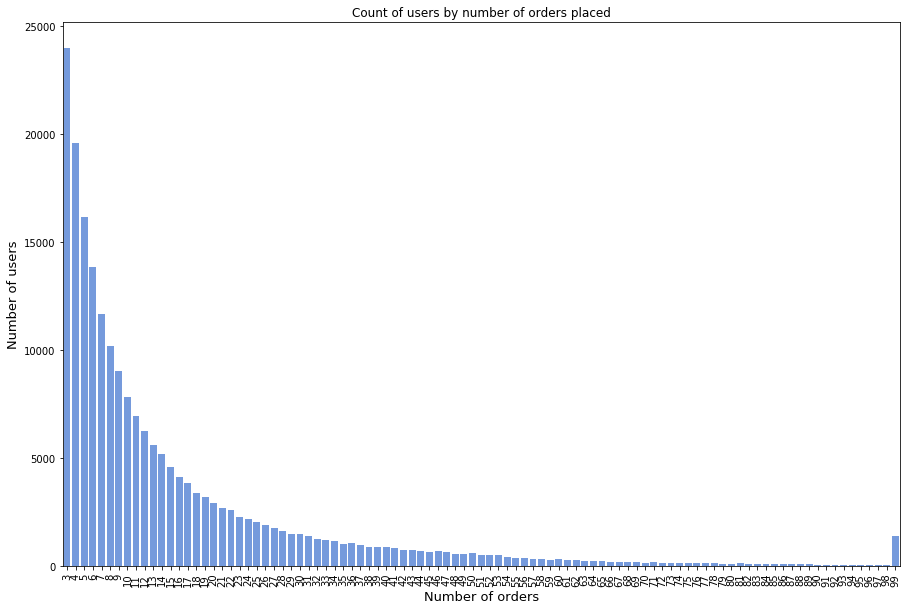

In [15]:
plt.figure(figsize=(15,10))
sns.barplot(x='Order_Count', y='Users',data=user_order, color='cornflowerblue')
plt.ylabel('Number of users', fontsize=13)
plt.xlabel('Number of orders', fontsize=13)
plt.xticks(rotation='vertical')
plt.title('Count of users by number of orders placed');

We see that it is a right skewed chart with a majority of users having less than 20 orders.

We will now look at how many products users generally buy in one order

#### Count of orders by number of products purchased

In [16]:
order_products = merged_data[['order_id','add_to_cart_order']]
order_products = order_products.groupby(['order_id']).agg({'add_to_cart_order' : ['max']}).reset_index()
order_products.columns = ['order_id','products']
order_products = order_products.groupby(['products']).agg({'order_id' : ['count']}).reset_index()
order_products.columns = ['no_of_products','orders']

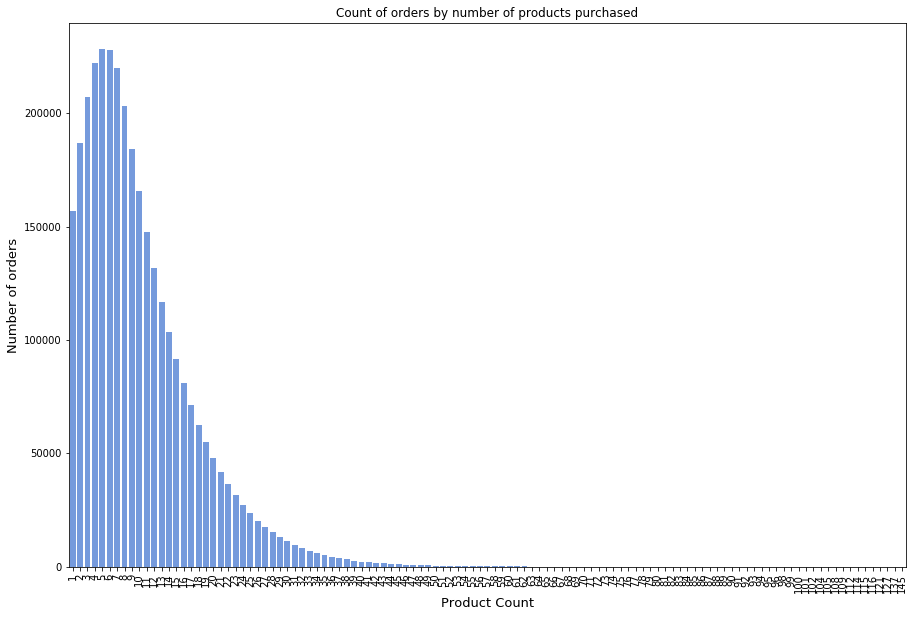

In [17]:
plt.figure(figsize=(15,10))
sns.barplot(x='no_of_products', y='orders',data=order_products, color='cornflowerblue')
plt.ylabel('Number of orders', fontsize=13)
plt.xlabel('Product Count', fontsize=13)
plt.xticks(rotation='vertical')
plt.title('Count of orders by number of products purchased');

The plot follows a right skew distribution and we notice that most of the orders contains upto 10 products in the order

We will look if the orders peak on a particular day of the week

#### Count of Orders by each Day in the Week 

In [18]:
orderperday = merged_data[['order_dow','order_id']].drop_duplicates().groupby('order_dow').agg({'order_id' : ['count']}).reset_index()
orderperday.columns = ['Day_Week','Orders']
orderperday.shape

(7, 2)

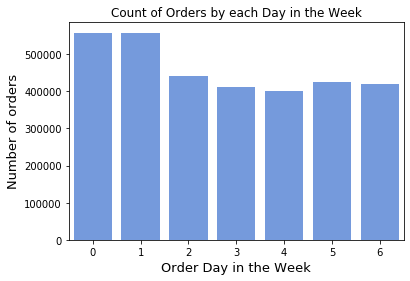

In [19]:
sns.barplot(x='Day_Week', y='Orders',data=orderperday, color='cornflowerblue')
plt.ylabel('Number of orders', fontsize=13)
plt.xlabel('Order Day in the Week', fontsize=13)
plt.title('Count of Orders by each Day in the Week');

We see that most of the orders are placed on day = 0 and day = 1.

#### Count of Orders by Hour in each Day

In [20]:
orderperhour = merged_data[['order_hour_of_day','order_id']].drop_duplicates().groupby('order_hour_of_day').agg({'order_id' : ['count']}).reset_index()
orderperhour.columns = ['Day_hour','Orders']
orderperhour.shape

(24, 2)

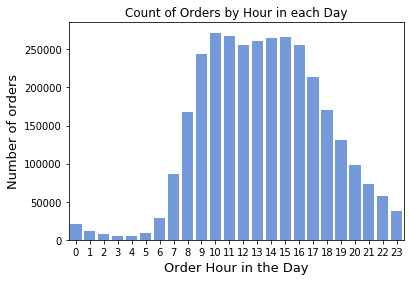

In [21]:
sns.barplot(x='Day_hour', y='Orders',data=orderperhour, color='cornflowerblue')
plt.ylabel('Number of orders', fontsize=13)
plt.xlabel('Order Hour in the Day', fontsize=13)
plt.title('Count of Orders by Hour in each Day');

Most of the ordering activity occurs between 9AM to 4PM before the number of orders placed goes down.

We will now check how often customers place orders on Instacart

#### Distribution showing how frequently users order 

In [22]:
customerorderprior = merged_data[['user_id','order_id','days_since_prior_order']].drop_duplicates()
customerorderprior = customerorderprior.loc[customerorderprior['days_since_prior_order'] != '999']
customerorderprior = customerorderprior.astype('int64', copy = False)
customerorderprior.head()

,user_id,order_id,days_since_prior_order
0,202279,2,8
1,153404,26,7
2,23750,120,10
3,58707,327,8
4,166654,390,9


In [23]:
#customerorderprior.groupby(['user_id'])['days_since_prior_order'].agg(pd.Series.mode).to_frame()
customerorderprior = customerorderprior.groupby('user_id')['days_since_prior_order'].apply(lambda x: x.value_counts().index[0]).reset_index()

In [24]:
customerorderprior.head()
#print ("\nUnique values :  \n",customerorderprior.nunique())

,user_id,days_since_prior_order
0,1,14
1,2,8
2,3,7
3,4,15
4,5,19


In [25]:
customerorderprior = customerorderprior.groupby('days_since_prior_order').agg({'user_id' : ['count']}).reset_index()
customerorderprior.columns = ['days_since_prior_order','users']
customerorderprior.head()

,days_since_prior_order,users
0,0,1029
1,1,3393
2,2,5792
3,3,7931
4,4,7019


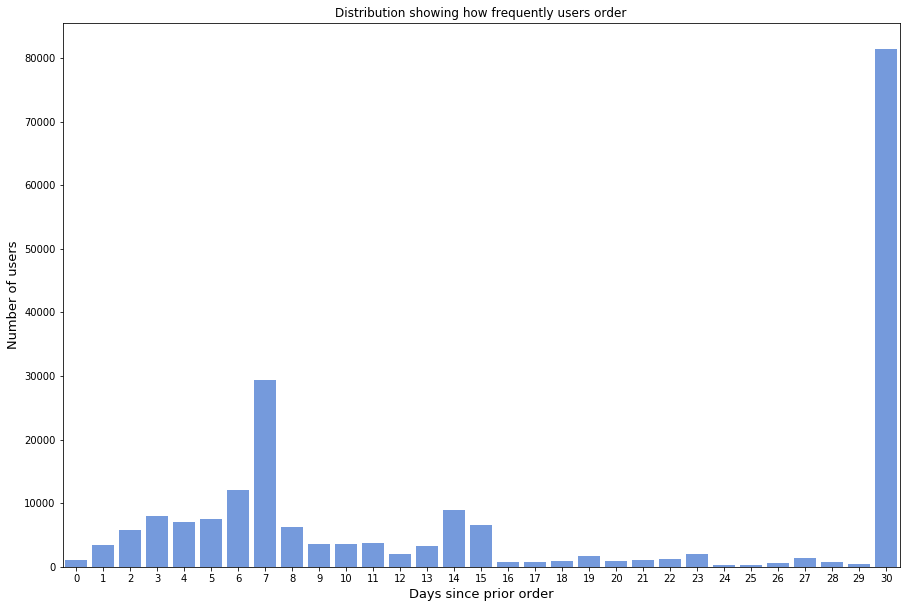

In [26]:
plt.figure(figsize=(15,10))
sns.barplot(x='days_since_prior_order', y='users',data=customerorderprior, color='cornflowerblue')
plt.ylabel('Number of users', fontsize=13)
plt.xlabel('Days since prior order', fontsize=13)
plt.title('Distribution showing how frequently users order');

The customers who order frequently i.e. every week can be targeted for experimentation with perishable products.

We will go ahead and see what are the products that are driving the orders i.e. the rank of the product in the cart should be 1

#### Top 25 products which are driving orders 

In [27]:
productorderpreference = merged_data[['order_id','product_id','add_to_cart_order']]
productorderpreference = productorderpreference[(productorderpreference.add_to_cart_order == 1)]
productorderpreference = productorderpreference[['order_id','product_id']]
productorderpreference = productorderpreference.groupby('product_id').agg({'order_id' : ['count']}).reset_index()
productorderpreference.columns = ['product_id','orders']
productorderpreference['orderspercent'] = productorderpreference['orders']/productorderpreference['orders'].sum()
productorderpreference = productorderpreference.sort_values(by='orderspercent', ascending=False)

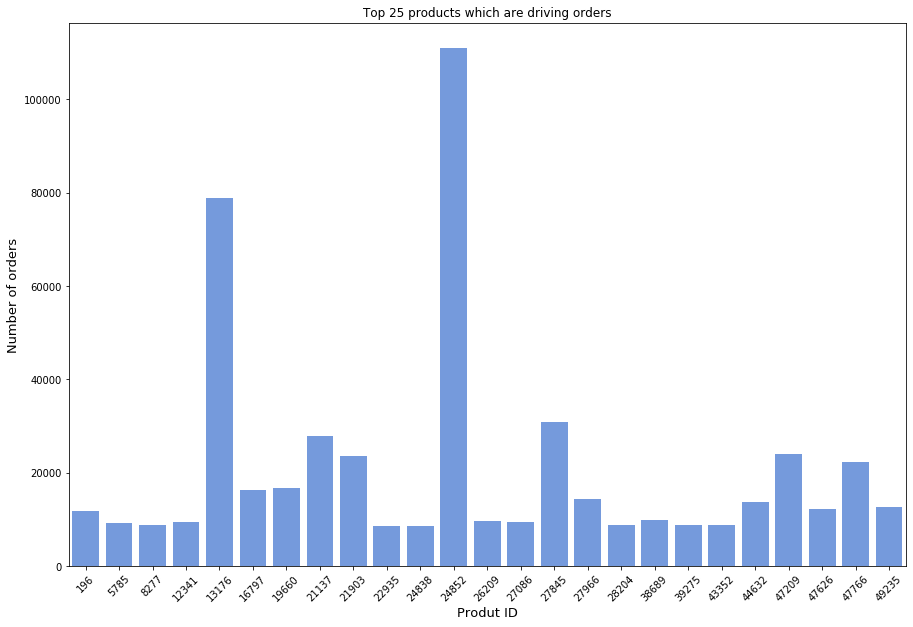

In [28]:
plt.figure(figsize=(15,10))
sns.barplot(x='product_id', y='orders',data=productorderpreference.iloc[:25, :], color='cornflowerblue')
plt.ylabel('Number of orders', fontsize=13)
plt.xlabel('Produt ID', fontsize=13)
plt.title('Top 25 products which are driving orders')
plt.xticks(rotation = 45);

Let us check what is the order percent for these 25 products

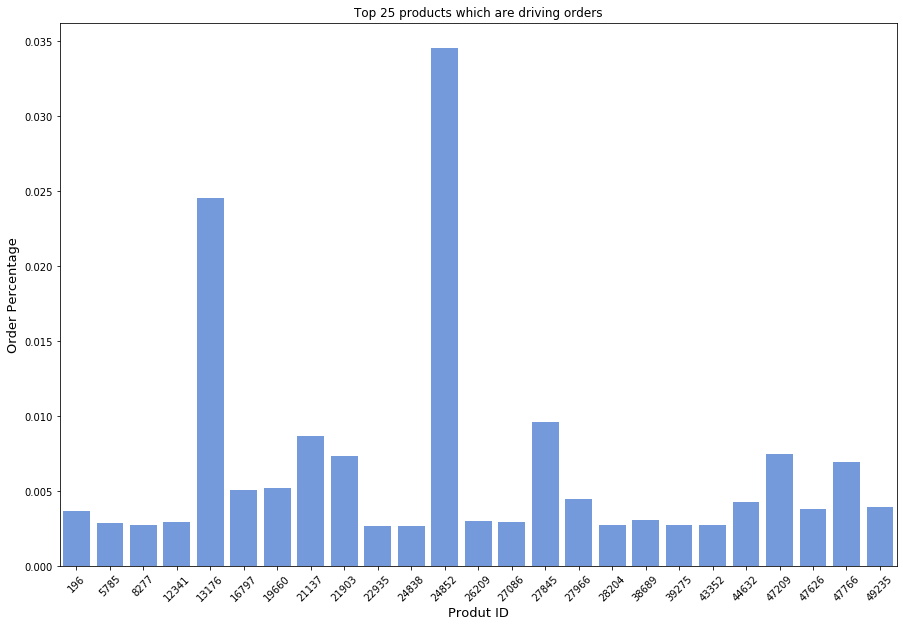

In [29]:
plt.figure(figsize=(15,10))
sns.barplot(x='product_id', y='orderspercent',data=productorderpreference.iloc[:25, :], color='cornflowerblue')
plt.ylabel('Order Percentage', fontsize=13)
plt.xlabel('Produt ID', fontsize=13)
plt.title('Top 25 products which are driving orders');
plt.xticks(rotation = 45);

#### Top 2 products which are driving most of the orders 

The top 2 products which are driving most of the orders are 24852 and 13176. They are present in 3.5% and 2.5% of all the orders. Let us see what department and aisle these products belong to.

In [30]:
Top2drivingproducts = merged_data[(merged_data.product_id == 24852) | (merged_data.product_id == 13176)]
Top2drivingproducts = Top2drivingproducts[['product_id','product_name','aisle','department']].drop_duplicates()
Top2drivingproducts

,product_id,product_name,aisle,department
10597350,13176,Bag of Organic Bananas,fresh fruits,produce
11196487,24852,Banana,fresh fruits,produce


Both the top 2 products are from the 'produce' department and the 'fresh fruits' aisle

We will check how many of the products are being re-ordered across departments and aisles. Let us plot the top 20 departmenst and aisles with highest re-order ratio

#### Departments and their highest re-order percentage 

In [31]:
department_re_order = merged_data.groupby('department').agg({'reordered' : ['mean']}).reset_index()
department_re_order.columns = ['department','re_order_ratio']
department_re_order = department_re_order.sort_values(by='re_order_ratio', ascending=False)

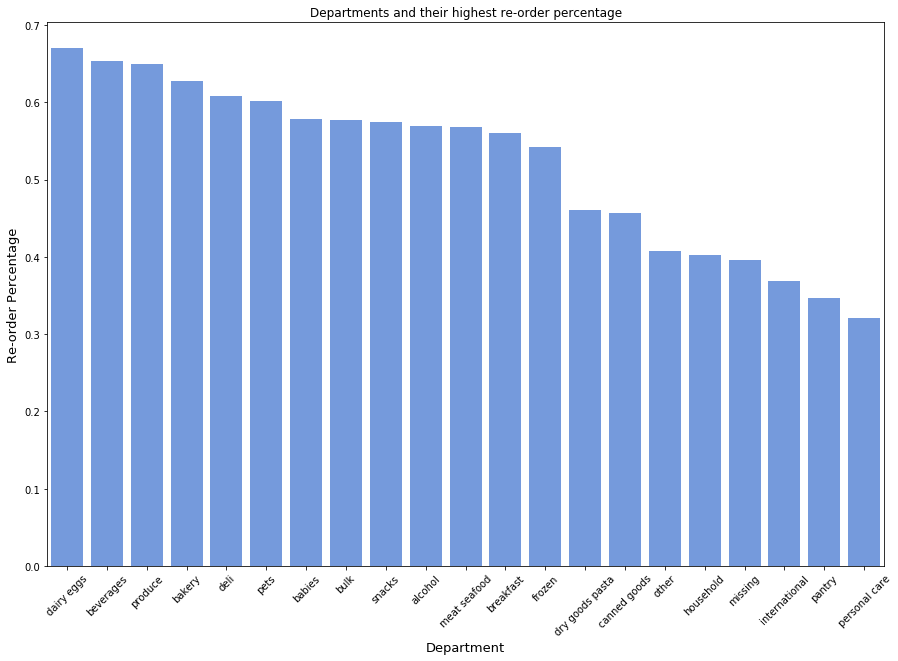

In [32]:
plt.figure(figsize=(15,10))
sns.barplot(x='department', y='re_order_ratio',data=department_re_order, color='cornflowerblue')
plt.ylabel('Re-order Percentage', fontsize=13)
plt.xlabel('Department', fontsize=13)
plt.title('Departments and their highest re-order percentage');
plt.xticks(rotation = 45);

Departments dairy eggs, beverages, and produce are the top 3 departments with highest re-order percentage. International, pantry and personal care are the departments with the lowest re-order percentage.

We will now repeat the same exercise for aisles. As the number of aisles are 134, we will look at the top 20 aisles with highest re-order percentage.

#### Top 20 aisles with highest re-order percentage 

In [33]:
aisle_re_order = merged_data.groupby('aisle').agg({'reordered' : ['mean']}).reset_index()
aisle_re_order.columns = ['aisle','re_order_ratio']
aisle_re_order = aisle_re_order.sort_values(by='re_order_ratio', ascending=False)

In [34]:
aisle_re_order

,aisle,re_order_ratio
83,milk,0.781428
131,water seltzer sparkling water,0.729593
50,fresh fruits,0.718104
41,eggs,0.705366
119,soy lactosefree,0.692551
...,...,...
8,beauty,0.212062
76,kitchen supplies,0.195377
47,first aid,0.194812
7,baking supplies decor,0.167229


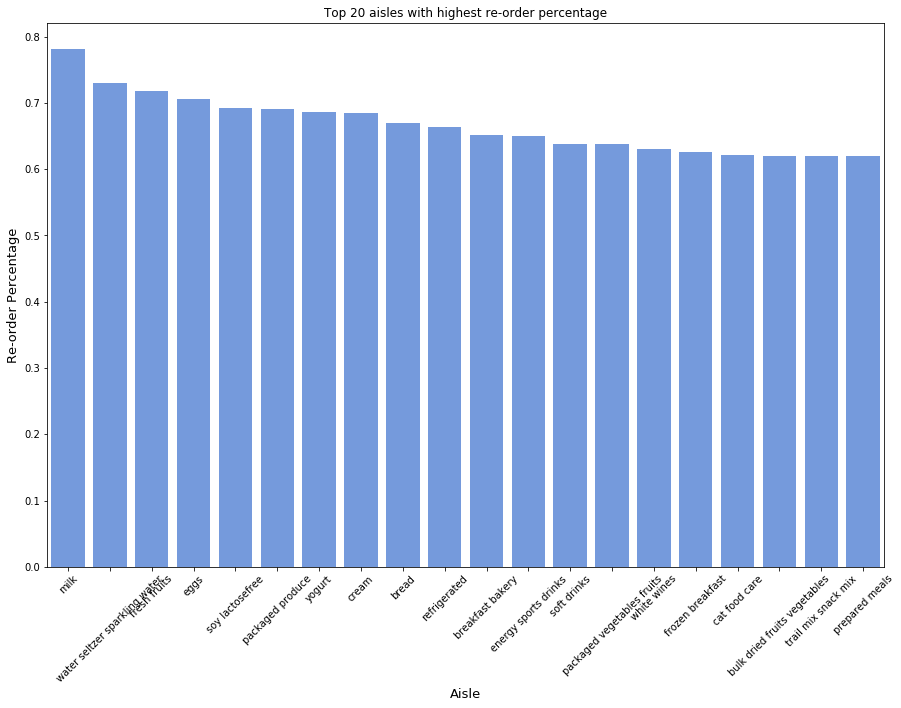

In [35]:
plt.figure(figsize=(15,10))
sns.barplot(x='aisle', y='re_order_ratio',data=aisle_re_order.iloc[:20, :], color='cornflowerblue')
plt.ylabel('Re-order Percentage', fontsize=13)
plt.xlabel('Aisle', fontsize=13)
plt.title('Top 20 aisles with highest re-order percentage');
plt.xticks(rotation = 45);

The top 3 aisles with highest re-order percentage are milk, water seltzer sparkling water, and fresh fruits. The bottom 3 aisles with the lowest re-order percentage are spices seasonings, baking supplies decor, and first - aid.

Let us look at the re-order percentage by both the day of week and hour of the day

#### Reorder percent by day of week and hour of day 

In [36]:
re_order_pattern = merged_data.groupby(['order_dow','order_hour_of_day']).agg({'reordered' : ['mean']}).reset_index()
re_order_pattern.columns = ['order_dow','order_hour_of_day','re_order_percent']
re_order_pattern = re_order_pattern.pivot('order_dow','order_hour_of_day','re_order_percent')

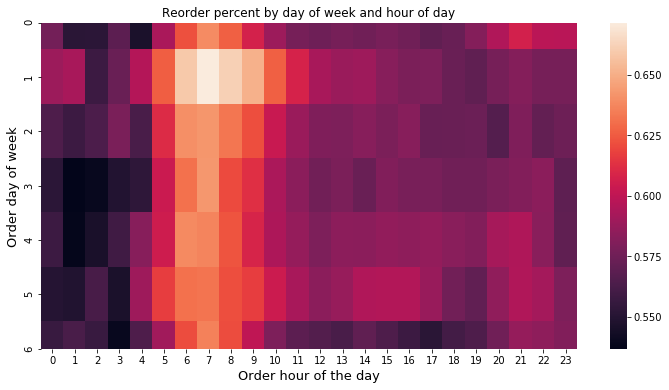

In [37]:
plt.figure(figsize=(12,6))
sns.heatmap(re_order_pattern)
plt.ylabel('Order day of week', fontsize=13)
plt.xlabel('Order hour of the day', fontsize=13)
plt.title("Reorder percent by day of week and hour of day");

Most of the products that are re-ordered occur between 6AM to 9AM thriughout the week. The highest re-order percentage is on day 1 at 7AM.

We can check if the order in which the products are added to the cart influence the re-ordering of the product i.e. we will be checking if the hypothesis of "Sooner the products are added to the cart, higher the re-order percentage" is validated.

#### Relation between Add to cart order and Reorder ratio 

In [38]:
# Max add to cart order in the dataset
merged_data['add_to_cart_order'].max()
merged_data['add_to_cart_order'].quantile(0.999)

49.0

While the maximum number of products added to the cart is 145, we see that the 99.9% of the products have a max add to cart order of 49. So, let us deal with products which have add to cart order of less than equal to 49.

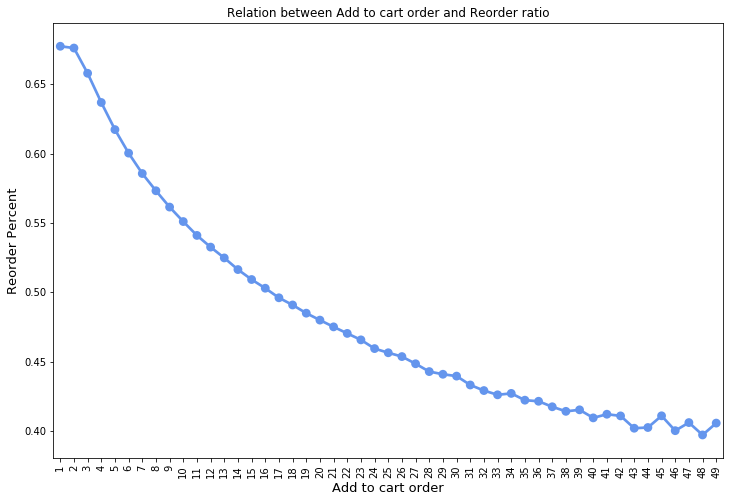

In [39]:
add_to_cart_reorder = merged_data[(merged_data.add_to_cart_order <= 49)]
add_to_cart_reorder = add_to_cart_reorder.groupby(['add_to_cart_order']).agg({'reordered' : ['mean']}).reset_index()
add_to_cart_reorder.columns = ['add_to_cart_order','re_order_percent']
plt.figure(figsize=(12,8))
sns.pointplot(add_to_cart_reorder['add_to_cart_order'].values, add_to_cart_reorder['re_order_percent'].values, alpha=0.8, color='cornflowerblue')
plt.ylabel('Reorder Percent', fontsize=13)
plt.xlabel('Add to cart order', fontsize=13)
plt.title("Relation between Add to cart order and Reorder ratio")
plt.xticks(rotation='vertical')
plt.show()

There is a very strong inverse relation between add to cart order and re-order percent. We can see that as the order in which the product is added to the cart increases, the re-order percent decreases.

#### Count of orders by Department 

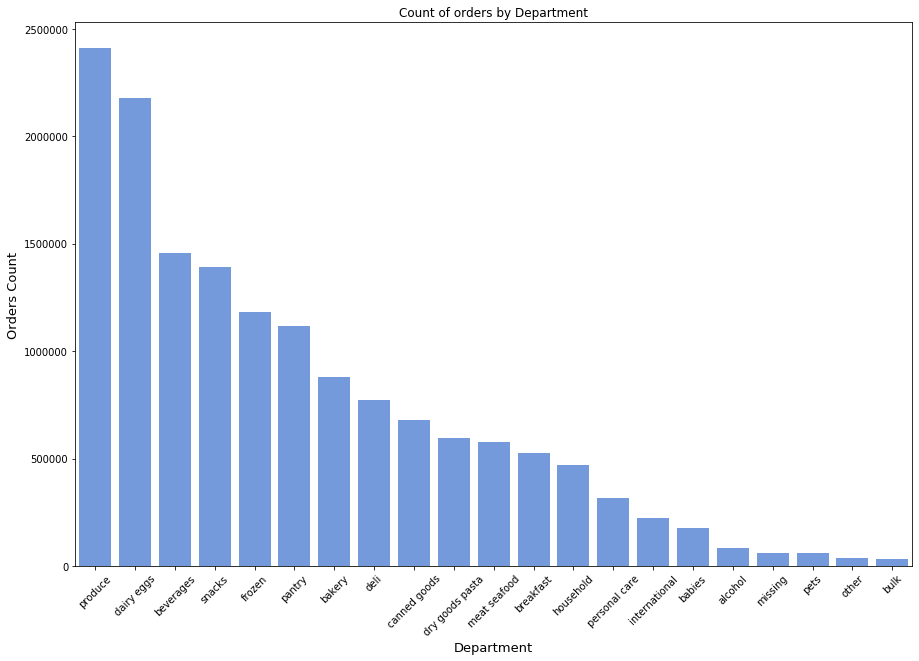

In [40]:
orders_department = merged_data[['order_id', 'department']].drop_duplicates().groupby(by=['department']).agg({'order_id' : ['count']}).reset_index()
orders_department.columns = ['department', 'orders_count']
plt.figure(figsize=(15,10))
sns.barplot(x='department', y='orders_count',data=orders_department.sort_values(by='orders_count', ascending=False), color='cornflowerblue')
plt.ylabel('Orders Count', fontsize=13)
plt.xlabel('Department', fontsize=13)
plt.title('Count of orders by Department');
plt.xticks(rotation = 45);

#### Count of orders by aisles 

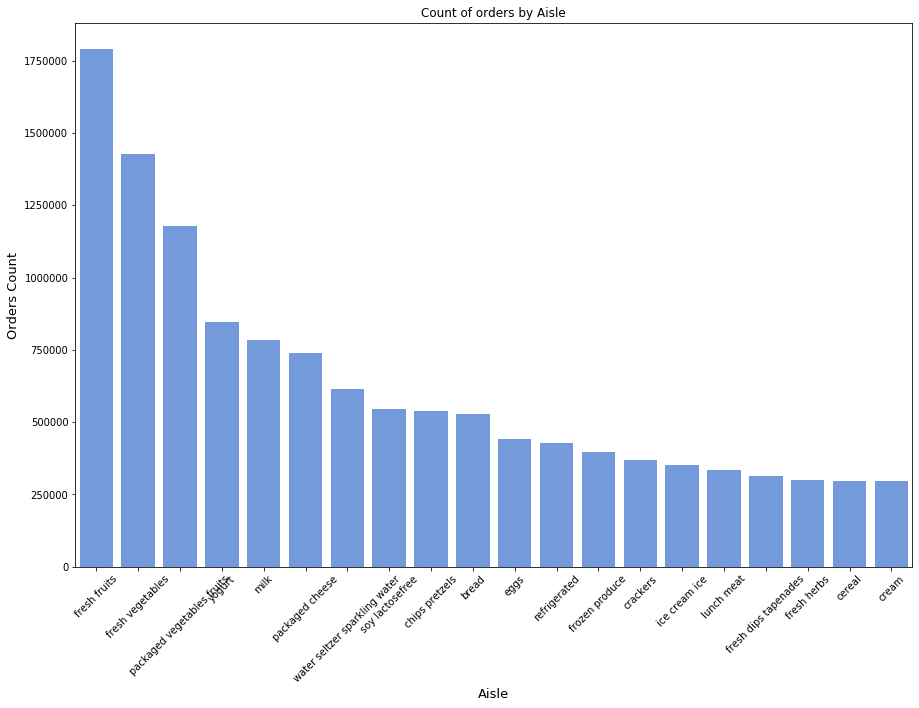

In [41]:
orders_aisle = merged_data[['order_id', 'aisle']].drop_duplicates().groupby(by=['aisle']).agg({'order_id' : ['count']}).reset_index()
orders_aisle.columns = ['aisle', 'orders_count']
plt.figure(figsize=(15,10))
sns.barplot(x='aisle', y='orders_count',data=orders_aisle.sort_values(by='orders_count', ascending=False).iloc[:20, :], color='cornflowerblue')
plt.ylabel('Orders Count', fontsize=13)
plt.xlabel('Aisle', fontsize=13)
plt.title('Count of orders by Aisle');
plt.xticks(rotation = 45);

#### Top Products sold in each Department 

In [42]:
orders_department_product = merged_data[['order_id', 'product_name', 'department']].drop_duplicates().groupby(by=['department', 'product_name']).agg({'order_id' : ['count']}).reset_index()
orders_department_product.columns = ['department', 'product_name','orders_count']
orders_department_product.sort_values(by='orders_count', ascending=False).groupby(by= ['department'], axis=0).head(1)

,department,product_name,orders_count
41849,produce,Banana,472565
13508,dairy eggs,Organic Whole Milk,137905
7318,beverages,Sparkling Water Grapefruit,75886
15528,deli,Original Hummus,71314
2144,bakery,100% Whole Wheat Bread,60816
18167,frozen,Blueberries,55946
26280,meat seafood,Boneless Skinless Chicken Breasts,50281
30237,pantry,Extra Virgin Olive Oil,50255
10250,canned goods,Organic Black Beans,38001
21928,household,100% Recycled Paper Towels,27864


#### Top Products sold in each Aisle 

In [43]:
orders_aisle_product = merged_data[['order_id', 'product_name', 'aisle']].drop_duplicates().groupby(by=['aisle', 'product_name']).agg({'order_id' : ['count']}).reset_index()
orders_aisle_product.columns = ['aisle', 'product_name','orders_count']
orders_aisle_product.sort_values(by='orders_count', ascending=False).groupby(by= ['aisle'], axis=0).head(1).head(10)

,aisle,product_name,orders_count
19407,fresh fruits,Banana,472565
36655,packaged vegetables fruits,Organic Baby Spinach,241921
30905,milk,Organic Whole Milk,137905
20378,fresh vegetables,Organic Yellow Onion,113426
14194,cream,Organic Half & Half,76360
48439,water seltzer sparkling water,Sparkling Water Grapefruit,75886
19277,fresh dips tapenades,Original Hummus,71314
19812,fresh herbs,Organic Cilantro,69524
4136,bread,100% Whole Wheat Bread,60816
35721,packaged cheese,Organic Whole String Cheese,59676


#### Orders containing only perishable orders

- Below, we are trying to evaluate what proportion of the total orders belong to only the perishable category

In [44]:
orders_perish = merged_data[['order_id', 'Perishables']].groupby(by=['order_id']).sum().reset_index()
orders_perish.columns = ['order_id', 'Perishables']
print("Proportion of perishables orders are "+"{:.2%}".format(orders_perish[orders_perish.Perishables==0].shape[0]/orders_perish.shape[0]));

Proportion of perishables orders are 8.51%


#### Users with only perishable orders

- Below, we are trying to evaluate what proportion of the total users are buying only pershable products on Instacart

In [45]:
users_perish = merged_data[['user_id', 'Perishables']].groupby(by=['user_id']).sum().reset_index()
users_perish.columns = ['user_id', 'Perishables']
print("Proportion of users who buy only perishables products are "+"{:.2%}".format(users_perish[users_perish.Perishables==0].shape[0]/users_perish.shape[0]));

Proportion of Users who buy only perishables products are 1.46%


#### Users with atleast 50% of perishable products on an average order

In [46]:
users_perish_proportion = merged_data[['user_id', 'Perishables']].groupby(by=['user_id']).agg({'Perishables' : ['mean']}).reset_index()
users_perish_proportion.columns = ['user_id', 'Perishables_proportion']
print("Proportion of Users who buy atleast 50% perishables products are "+"{:.2%}".format(users_perish_proportion[users_perish_proportion.Perishables_proportion>0.5].shape[0]/users_perish_proportion.shape[0]));

Proportion of Users who buy atleast 50% perishables products are 57.95%


#### Average re-ordered products in an order 

In [47]:
# percentage of re-orders
print("On an average, the re-ordered products in an order are "+"{:.2%}".format(merged_data.reordered.sum() / merged_data.shape[0]))

On an average, the re-ordered products in an order are 58.97%


#### Average Non re-ordered products in an order

- Now that we have seen 59% of the products are re-ordered, there will also be situations when none of the products are re-ordered. Let us check that now.

In [48]:
grouped_df = merged_data.groupby("order_id")["reordered"].aggregate("sum").reset_index()
grouped_df["reordered"].ix[grouped_df["reordered"]>1] = 1
grouped_df.reordered.value_counts() / grouped_df.shape[0]

1    0.879151
0    0.120849
Name: reordered, dtype: float64

- About 12% of the orders in the data has no re-ordered items

## Data Modeling

#### Association Rules

We will implement association rules i.e. understand what product combinations occur the most. These insights will feed into the recommenders such as "Frequently bought together", "Customer who purchased item A also bought item B" etc.

We will use the order_products table for this as we will have to prepare the data in a format such that we just have order information i.e. order id and the corresponding product ids in the order. We will join back the product names after we form the association rules

In [50]:
orders_products_train.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


Convert from DataFrame to a Series, with order_id as index and item_id as value

In [52]:
orders_products_model1 = orders_products_train.set_index('order_id')['product_id'].rename('item_id')
display(orders_products_model1.head(10))

order_id
2    33120
2    28985
2     9327
2    45918
2    30035
2    17794
2    40141
2     1819
2    43668
3    33754
Name: item_id, dtype: int64

In [57]:
print ("Total Products Bought (Rows)     : " ,len(orders_products_model1))
print ("\nUnique values :  \n",orders_products_model1.nunique())

Total Products Bought (Rows)     :  32434489

Unique values :  
 49677


In [63]:
type(orders_products_model1)

pandas.core.series.Series

We have ~3.25M orders and ~50K unique products.

We will define fuctions in this module that we will be using on our dataset later to get the association rules

In [75]:
# Returns frequency counts for items and item pairs
def freq(iterable):
    if type(iterable) == pd.core.series.Series:
        return iterable.value_counts().rename("freq")
    else: 
        return pd.Series(col.Counter(iterable)).rename("freq")

    
# Returns number of unique orders
def order_count(order_item):
    return len(set(order_item.index))


# Returns generator that yields item pairs, one at a time
def get_item_pairs(order_item):
    order_item = order_item.reset_index().as_matrix()
    for order_id, order_object in iterto.groupby(order_item, lambda x: x[0]):
        item_list = [item[1] for item in order_object]
              
        for item_pair in iterto.combinations(item_list, 2):
            yield item_pair
            

# Returns frequency and support associated with item
def merge_item_stats(item_pairs, item_stats):
    return (item_pairs
                .merge(item_stats.rename(columns={'freq': 'freqA', 'support': 'supportA'}), left_on='item_A', right_index=True)
                .merge(item_stats.rename(columns={'freq': 'freqB', 'support': 'supportB'}), left_on='item_B', right_index=True))


# Returns name associated with item
def merge_item_name(rules, item_name):
    columns = ['itemA','itemB','freqAB','supportAB','freqA','supportA','freqB','supportB', 
               'confidenceAtoB','confidenceBtoA','lift']
    rules = (rules
                .merge(item_name.rename(columns={'item_name': 'itemA'}), left_on='item_A', right_on='item_id')
                .merge(item_name.rename(columns={'item_name': 'itemB'}), left_on='item_B', right_on='item_id'))
    return rules[columns]

Defining association function

In [76]:
def association_rules(order_item, min_support):

    print("Starting order_item: {:22d}".format(len(order_item)))


    # Calculate item frequency and support
    item_stats             = freq(order_item).to_frame("freq")
    item_stats['support']  = item_stats['freq'] / order_count(order_item) * 100


    # Filter from order_item items below min support 
    qualifying_items       = item_stats[item_stats['support'] >= min_support].index
    order_item             = order_item[order_item.isin(qualifying_items)]

    print("Items with support >= {}: {:15d}".format(min_support, len(qualifying_items)))
    print("Remaining order_item: {:21d}".format(len(order_item)))


    # Filter from order_item orders with less than 2 items
    order_size             = freq(order_item.index)
    qualifying_orders      = order_size[order_size >= 2].index
    order_item             = order_item[order_item.index.isin(qualifying_orders)]

    print("Remaining orders with 2+ items: {:11d}".format(len(qualifying_orders)))
    print("Remaining order_item: {:21d}".format(len(order_item)))


    # Recalculate item frequency and support
    item_stats             = freq(order_item).to_frame("freq")
    item_stats['support']  = item_stats['freq'] / order_count(order_item) * 100


    # Get item pairs generator
    item_pair_gen          = get_item_pairs(order_item)


    # Calculate item pair frequency and support
    item_pairs              = freq(item_pair_gen).to_frame("freqAB")
    item_pairs['supportAB'] = item_pairs['freqAB'] / len(qualifying_orders) * 100

    print("Item pairs: {:31d}".format(len(item_pairs)))


    # Filter from item_pairs those below min support
    item_pairs              = item_pairs[item_pairs['supportAB'] >= min_support]

    print("Item pairs with support >= {}: {:10d}\n".format(min_support, len(item_pairs)))


    # Create table of association rules and compute relevant metrics
    item_pairs = item_pairs.reset_index().rename(columns={'level_0': 'item_A', 'level_1': 'item_B'})
    item_pairs = merge_item_stats(item_pairs, item_stats)
    
    item_pairs['confidenceAtoB'] = item_pairs['supportAB'] / item_pairs['supportA']
    item_pairs['confidenceBtoA'] = item_pairs['supportAB'] / item_pairs['supportB']
    item_pairs['lift']           = item_pairs['supportAB'] / (item_pairs['supportA'] * item_pairs['supportB'])
    
    
    # Return association rules sorted by lift in descending order
    return item_pairs.sort_values('lift', ascending=False)



Forming association rules. We are forming rules having support greater than 1%, we increase or decrease this number depending on the number of rules we form from this dataset.

In [77]:
%%time 
rules = association_rules(orders_products_model1, 0.01) 

Starting order_item:               32434489
Items with support >= 0.01:           10906
Remaining order_item:              29843570
Remaining orders with 2+ items:     3013325
Remaining order_item:              29662716
Item pairs:                        30622410
Item pairs with support >= 0.01:      48751

Wall time: 4min 54s


Notice we got ~49K rules here. We can tweak the support value to change the association rules i.e. increase the support to reduce the number of rules and vice versa.

We will run a loop to understand how many rules we get for values of support varying from 0.01 to 0.46

In [86]:
rule_count = list()
for i in np.arange(0.01, 0.5, 0.05):
    rules = association_rules(orders_products_model1, i)
    print([i, len(rules)])
    rule_count.append([i, len(rules)])

Starting order_item:               32434489
Items with support >= 0.01:           10906
Remaining order_item:              29843570
Remaining orders with 2+ items:     3013325
Remaining order_item:              29662716
Item pairs:                        30622410
Item pairs with support >= 0.01:      48751

[0.01, 48751]
Starting order_item:               32434489
Items with support >= 0.060000000000000005:            2896
Remaining order_item:              23520257
Remaining orders with 2+ items:     2843101
Remaining order_item:              23251234
Item pairs:                         6292566
Item pairs with support >= 0.060000000000000005:       3504

[0.060000000000000005, 3504]
Starting order_item:               32434489
Items with support >= 0.11:            1615
Remaining order_item:              20197362
Remaining orders with 2+ items:     2707844
Remaining order_item:              19861576
Item pairs:                         2295621
Item pairs with support >= 0.11:       1341

We will choose the value of support to be 0.36 as we have around 180 rules.

In [87]:
%%time 
rules = association_rules(orders_products_model1,0.36 ) 

Starting order_item:               32434489
Items with support >= 0.36:             401
Remaining order_item:              12852900
Remaining orders with 2+ items:     2229393
Remaining order_item:              12329239
Item pairs:                          156795
Item pairs with support >= 0.36:        180

Wall time: 1min 52s


We will join the item id with its name and then display the association rules just formed

In [88]:
products_sub = products.rename(columns={'product_id':'item_id', 'product_name':'item_name'})
rules_final = merge_item_name(rules, products_sub).sort_values('lift', ascending=False)
display(rules_final)

,itemA,itemB,freqAB,supportAB,freqA,supportA,freqB,supportB,confidenceAtoB,confidenceBtoA,lift
0,Sparkling Water Grapefruit,Lime Sparkling Water,8186,0.367185,72330,3.244381,44792,2.009157,0.113176,0.182756,0.056330
1,Organic Yellow Onion,Organic Garlic,12641,0.567015,111721,5.011274,108543,4.868724,0.113148,0.116461,0.023240
21,Organic Cilantro,Limes,8870,0.397866,68441,3.069939,137302,6.158717,0.129601,0.064602,0.021043
30,Limes,Organic Cilantro,8695,0.390016,137302,6.158717,68441,3.069939,0.063328,0.127044,0.020628
66,Organic Garlic,Organic Yellow Onion,9432,0.423075,108543,4.868724,111721,5.011274,0.086896,0.084425,0.017340
...,...,...,...,...,...,...,...,...,...,...,...
55,Limes,Banana,9804,0.439761,137302,6.158717,444333,19.930672,0.071405,0.022065,0.003583
58,Organic Strawberries,Banana,17592,0.789094,257143,11.534216,444333,19.930672,0.068413,0.039592,0.003433
60,Organic Baby Spinach,Banana,15805,0.708937,235233,10.551437,444333,19.930672,0.067189,0.035570,0.003371
105,Organic Avocado,Bag of Organic Bananas,9024,0.404774,172415,7.733719,359692,16.134078,0.052339,0.025088,0.003244


In [144]:
%%time 
rules1 = association_rules(orders_products_model1,0.02) 
rules_final_check = merge_item_name(rules1, products_sub).sort_values('lift', ascending=False)
display(rules_final_check)

Starting order_item:               32434489
Items with support >= 0.02:            6985
Remaining order_item:              28050418
Remaining orders with 2+ items:     2975061
Remaining order_item:              27848926
Item pairs:                        20384055
Item pairs with support >= 0.02:      18153



,itemA,itemB,freqAB,supportAB,freqA,supportA,freqB,supportB,confidenceAtoB,confidenceBtoA,lift
0,Oh My Yog! Pacific Coast Strawberry Trilayer Y...,Oh My Yog! Organic Wild Quebec Blueberry Cream...,860,0.028907,2856,0.095998,2271,0.076335,0.301120,0.378688,3.944745
2,Unsweetened Blackberry Water,Raspberry Essence Water,660,0.022184,3108,0.104468,2025,0.068066,0.212355,0.325926,3.119850
3,Organic Fiber & Protein Pear Blueberry & Spina...,"Fiber & Protein Organic Pears, Raspberries, Bu...",606,0.020369,2782,0.093511,2167,0.072839,0.217829,0.279649,2.990560
4,Oh My Yog! Organic Wild Quebec Blueberry Cream...,Oh My Yog! Pacific Coast Strawberry Trilayer Y...,642,0.021579,2271,0.076335,2856,0.095998,0.282695,0.224790,2.944798
1,Oh My Yog! Pacific Coast Strawberry Trilayer Y...,Oh My Yog! Madagascar Vanilla Trilayer Yogyurt,640,0.021512,2856,0.095998,2567,0.086284,0.224090,0.249318,2.597119
...,...,...,...,...,...,...,...,...,...,...,...
1181,Red Onion,Bag of Organic Bananas,1008,0.033882,42881,1.441349,376021,12.639102,0.023507,0.002681,0.001860
7291,Banana,Soda,864,0.029041,469627,15.785458,32674,1.098263,0.001840,0.026443,0.001675
146,Strawberries,Organic Strawberries,706,0.023731,141660,4.761583,263285,8.849735,0.004984,0.002682,0.000563
3600,Organic Strawberries,Strawberries,640,0.021512,263285,8.849735,141660,4.761583,0.002431,0.004518,0.000511


Wall time: 4min 8s


THIS WILL BE MODIFIED AFTER WE FIGURE OUT THE IDEAL NNUMBER OF RULES AND THE VALIDATION PART

#### Customer Segmentation - Clustering Analysis

We will segment customers based on the aisles from which they have shopped. For this purpose let us create a cross tab with user ids and aisles.

In [89]:
cust_aisle = pd.crosstab(merged_data['user_id'], merged_data['aisle'])
cust_aisle.head(10)

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
2,0,3,0,0,0,0,2,0,0,0,...,3,1,1,0,0,0,0,2,0,42
3,0,0,0,0,0,0,0,0,0,0,...,4,1,0,0,0,0,0,2,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
5,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,5
8,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,6,0,2,0,0,0,...,0,0,0,0,0,0,0,2,0,19


Let us look at the mean, median, and mode for this dataset

In [94]:
cust_aisle.describe()

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
count,206209.000000,206209.000000,206209.000000,206209.000000,206209.000000,206209.000000,206209.000000,206209.000000,206209.000000,206209.000000,...,206209.000000,206209.000000,206209.000000,206209.000000,206209.000000,206209.000000,206209.000000,206209.000000,206209.000000,206209.000000
mean,0.096266,0.807952,0.039572,0.041613,1.854701,0.169105,1.584276,0.114893,0.029911,0.235960,...,1.403431,1.209166,0.627878,0.937384,0.172592,0.155575,0.218511,4.080971,0.148189,7.043063
std,0.728536,2.438233,0.532817,0.371400,11.144575,1.109605,3.819624,0.574782,0.272030,3.036664,...,3.441071,5.316325,3.316950,2.831621,1.300779,0.762345,1.103784,11.275365,1.743848,18.399355
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
75%,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,4.000000,0.000000,7.000000
max,54.000000,107.000000,47.000000,27.000000,806.000000,62.000000,160.000000,68.000000,26.000000,541.000000,...,130.000000,382.000000,241.000000,103.000000,83.000000,71.000000,72.000000,510.000000,161.000000,1522.000000


Although we perform k-means clustering here, there is no need to standardize variables as all the columns contain quantities. Now, we will try and understand how many clusters should be considered. We will use elbow curve method for this.

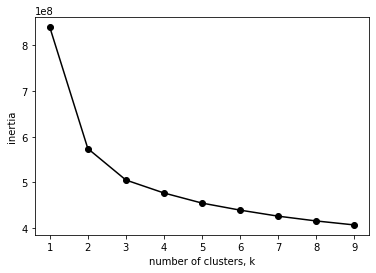

In [98]:
array_cust_aisle = cust_aisle.values
ks = range(1,10) # Let us vary the number of clusters from 1 to 9
inertias = []
for k in ks:
    model = KMeans(n_clusters=k)    # Create a KMeans instance with k clusters: model
    model.fit(array_cust_aisle)                    # Fit the k-means model
    inertias.append(model.inertia_) # Append the inertia to the list of inertias
    
plt.plot(ks, inertias, '-o', color='black') # Plotting the elbow curve'.
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

The drop in inertia reduces after number of clusters > 4. So, we go ahead with 4 clusters for the segmentation exercise. But, we will check how much of variability is explained by number of PCA components = 4.

In [111]:
#Decomposing the features into 4 using PCA (seeing the above plot, n_components = 6)
pca = decomposition.PCA(n_components=4)
pca_user_order = pca.fit_transform(array_cust_aisle)
pca.explained_variance_ratio_.sum()

0.6659987959994454

We see that 4 principal components explain about 66.5% of variability in the dataset. We will try with number of components = 9

In [112]:
pca = decomposition.PCA(n_components=9)
pca_user_order = pca.fit_transform(array_cust_aisle)
pca.explained_variance_ratio_.sum()

0.7714699179773211

If we increase the number of PCA components to 9, ~77% of variability is explained

In [113]:
pca = decomposition.PCA(n_components=5)
pca_user_order = pca.fit_transform(array_cust_aisle)
pca.explained_variance_ratio_.sum()

0.6953453947429625

For pca components = 5, ~70% of variability is explained. We go ahead with this as we do not want to increase the number of clusters to 9 for a increase of 7% in variability being explained. However, note that this is a tradeoff between the model accuracy and computation load and this decision varies according to the business case.

Plotting the variability explained by each of additional PCA components.

Text(0, 0.5, 'variance %')

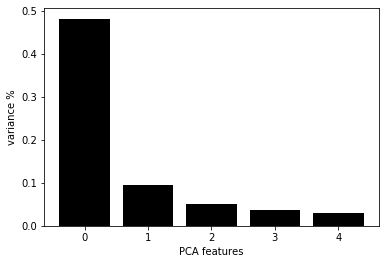

In [114]:
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')

We can see from the 2nd PCA component, the additional variability being explained keeps decreasing.

In [124]:
pca_user_order[:,4]

array([ 0.26916065, -6.92094044, -0.44224581, ...,  1.71793131,
        9.03606325,  1.53986163])

In [126]:
#Build the model (kmeans using 5 clusters)
kmeans = KMeans(n_clusters=5)
array_cust_aisle_clustered = kmeans.fit_predict(pca_user_order) #fit_predict on chosen components only.

Let us visualize the clusters now

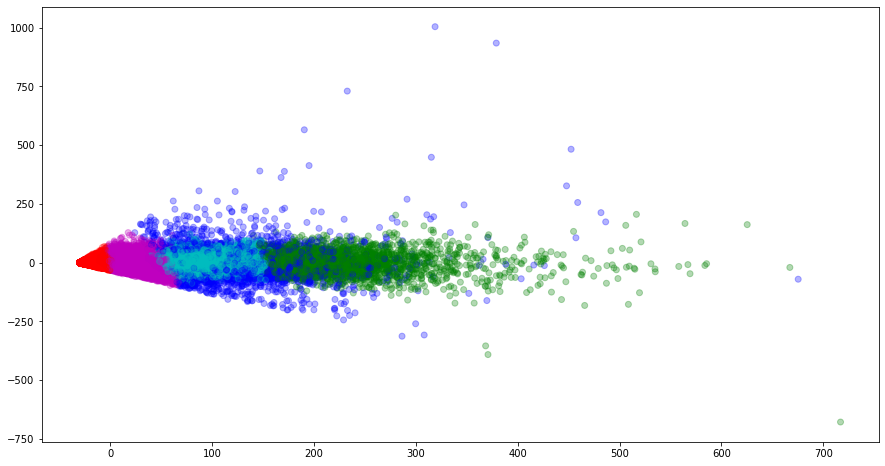

In [133]:
#Visualize it.

label_color_mapping = {0:'r', 1: 'g', 2: 'b',3:'c' , 4:'m'}
label_color = [label_color_mapping[l] for l in array_cust_aisle_clustered]

#Scatterplot showing the cluster to which each user_id belongs.
plt.figure(figsize = (15,8))
plt.scatter(pca_user_order[:,0],pca_user_order[:,2], c= label_color, alpha=0.3) 
plt.show()

Assigning the cluster to each user

In [134]:
cust_aisle['cluster']=array_cust_aisle_clustered

Let us check how many users fall into each of the clusters.

In [135]:
#Checking cluster concentration. 
cust_aisle['cluster'].value_counts().sort_values(ascending = False)

0    147096
4     40534
3     12095
2      3616
1      2868
Name: cluster, dtype: int64

Cluster 0 has the highest number of users at 147K followed by cluster 4 havng 40K users.

In [136]:
cust_aisle

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt,cluster
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,3,0,0,0,0,2,0,0,0,...,1,1,0,0,0,0,2,0,42,4
3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,2,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
5,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206205,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,5,0
206206,0,4,0,0,0,0,4,1,0,0,...,0,0,0,0,1,0,1,0,0,0
206207,0,0,0,0,1,0,0,0,0,0,...,4,0,2,1,0,0,11,0,15,4


In [137]:
c0 = cust_aisle[cust_aisle['cluster']==0].drop('cluster',axis=1).mean()
c1 = cust_aisle[cust_aisle['cluster']==1].drop('cluster',axis=1).mean()
c2 = cust_aisle[cust_aisle['cluster']==2].drop('cluster',axis=1).mean()
c3 = cust_aisle[cust_aisle['cluster']==3].drop('cluster',axis=1).mean()
c4 = cust_aisle[cust_aisle['cluster']==4].drop('cluster',axis=1).mean()

In [138]:
c0.sort_values(ascending=False)[0:10]

aisle
fresh fruits                     5.637284
fresh vegetables                 5.203677
packaged vegetables fruits       3.067072
yogurt                           2.509239
water seltzer sparkling water    2.195002
packaged cheese                  2.002189
milk                             1.757893
chips pretzels                   1.738919
ice cream ice                    1.362777
soft drinks                      1.296704
dtype: float64

In [139]:
c1.sort_values(ascending=False)[0:10]

aisle
fresh vegetables              175.968271
fresh fruits                  148.789052
packaged vegetables fruits     67.242678
yogurt                         37.939679
packaged cheese                29.165621
milk                           27.089261
fresh herbs                    19.203626
soy lactosefree                19.010460
bread                          17.065900
frozen produce                 16.813459
dtype: float64

In [140]:
c2.sort_values(ascending=False)[0:10]

aisle
fresh fruits                     119.863108
yogurt                            75.754425
packaged vegetables fruits        43.129978
fresh vegetables                  41.034292
milk                              30.362832
packaged cheese                   27.523783
water seltzer sparkling water     24.800055
chips pretzels                    22.040929
energy granola bars               20.626106
baby food formula                 20.504425
dtype: float64

In [141]:
c3.sort_values(ascending=False)[0:10]

aisle
fresh vegetables                 78.025217
fresh fruits                     63.406614
packaged vegetables fruits       31.917817
yogurt                           17.873832
packaged cheese                  14.866143
milk                             12.736007
soy lactosefree                  10.212650
water seltzer sparkling water     9.152708
fresh herbs                       8.831253
frozen produce                    8.716742
dtype: float64

In [142]:
c4.sort_values(ascending=False)[0:10]

aisle
fresh fruits                     29.257191
fresh vegetables                 26.047491
packaged vegetables fruits       14.291780
yogurt                           11.948512
packaged cheese                   7.950609
milk                              7.176938
water seltzer sparkling water     6.902082
chips pretzels                    5.993684
soy lactosefree                   5.257537
refrigerated                      4.800094
dtype: float64

The aisles which differentiate customers from cluster 0 are soft drinks and ice cream. Refrigerated aisle seems to differentiate customers from cluster 4 whereas baby food formula and energy granola bars differentiate customers from cluster 2. Frozen produce is the aisle which differntiates customers from cluster 1 and 3.